# Appendix: Using the full data resolution

**Author:** Hannu Parviainen <br>
**Edited:** 24 August 2024

So far, we've always binned our data set along the wavelength to a significantly lower resolution from the native data resolution. However, **there's nothing really stopping us using the native data resolution, and this is what we will in most cases want to do when carrying out real transmission spectroscopy analyses.** The only drawback is that the model evaluation time will naturally be longer, but not prohibitively so.

Here we repeat the steps of [Example 3](03_increasing_data_resolution.ipynb), but use the native data resolution instead of binning to R=300.  

Instead of going for a coffee while the MCMC sampler is running, you just might want to go for a spanish-style extended lunch, leave the analysis running over night, or use a cluster.

In [1]:
%run ../setup_multiprocessing.py

In [2]:
%matplotlib inline

In [3]:
from multiprocessing import Pool
from xarray import load_dataset
from numpy import array, geomspace, linspace, diff, sqrt, newaxis, r_

from matplotlib.pyplot import subplots, setp

from easyts import EasyTS, TSData
from easyts.easyts import read_model, clean_knots

pargs = dict(figsize=(13,7), res_args=dict(pmin=5, pmax=95), 
             trs_args=dict(xscale='log', ylim=(2.0, 2.2), xticks=[0.6, 0.88, 1.16, 1.44, 1.72, 2.0, 2.30, 2.8]))

## Read the data

We read in the data as in the previous examples, but do not bin it along the wavelength. We also replace the original `error` values with white noise estimates calculated from the data, since there seems to be something funny in the provided values (it would seem that the errors provided with the data are variances rather than standard deviations, but I didn't find any mention about this in the data documentation). 

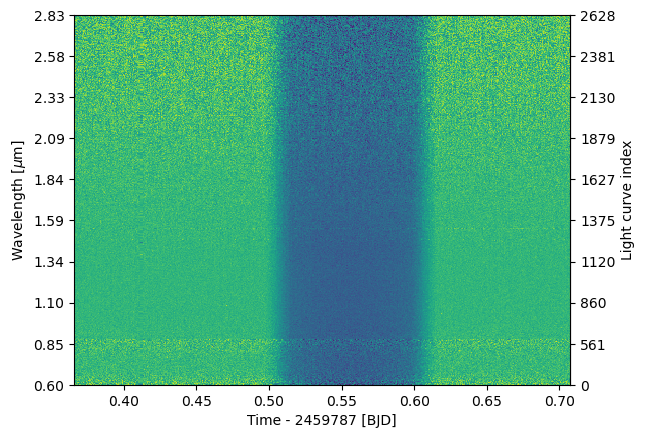

In [5]:
def read_data(fname):
    with load_dataset(fname) as ds:
        return TSData(time=ds.time.values, wavelength=ds.wavelength.values, fluxes=ds.flux.values, errors=ds.error.values)

d1 = read_data('data/nirHiss_order_1.h5')
d2 = read_data('data/nirHiss_order_2.h5')
d1.remove_outliers()
d2.crop_wavelength(0.6, d1.wllims[0])
d2.remove_outliers()
db = d2+d1
db.errors[:,:] = diff(db.fluxes).std(1)[:,newaxis]
ax = db.plot()

## Load the low-resolution model

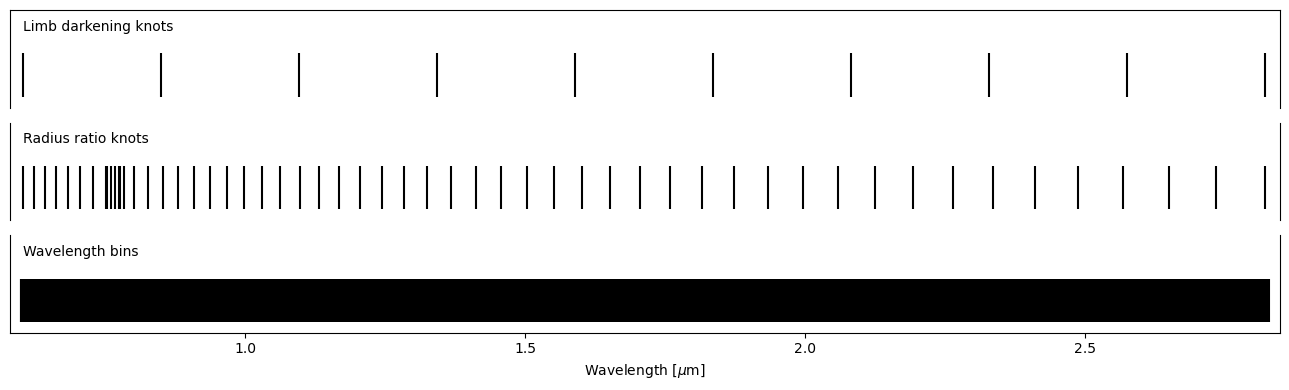

In [6]:
ts = read_model("01a_lowres_power2.fits", name='0xxa')
ts.set_data(db)

ts.set_radius_ratio_knots(r_[geomspace(ts.wavelength[0], 0.768-0.02, 10),
                          linspace(0.768-0.020, 0.768+0.02, 9),
                          linspace(0.855-0.055, 0.855+0.055, 13), 
                          geomspace(0.855+0.055, ts.wavelength[-1], 120)]
ts.plot_setup();

However, we again should not forget to normalise the new data set. 

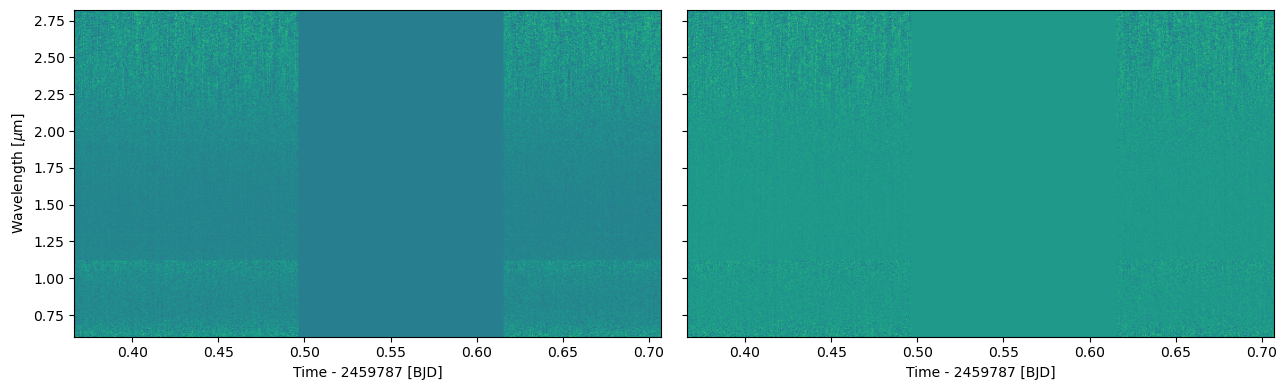

In [9]:
ts.normalize_baseline()
ts.plot_baseline();

## Fitting

In [11]:
x0 = ts.create_initial_population(400, 'mcmc', add_noise=True)

In [12]:
def lnpostf(pv):
    return ts.lnposterior(pv)

pool = Pool(8)

Global optimisation:   0%|          | 0/500 [00:00<?, ?it/s]

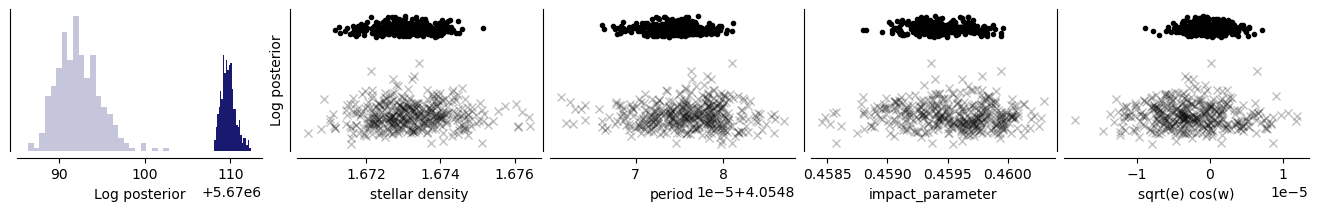

In [19]:
ts.fit(niter=2000, pool=pool, lnpost=lnpostf, initial_population=x0)

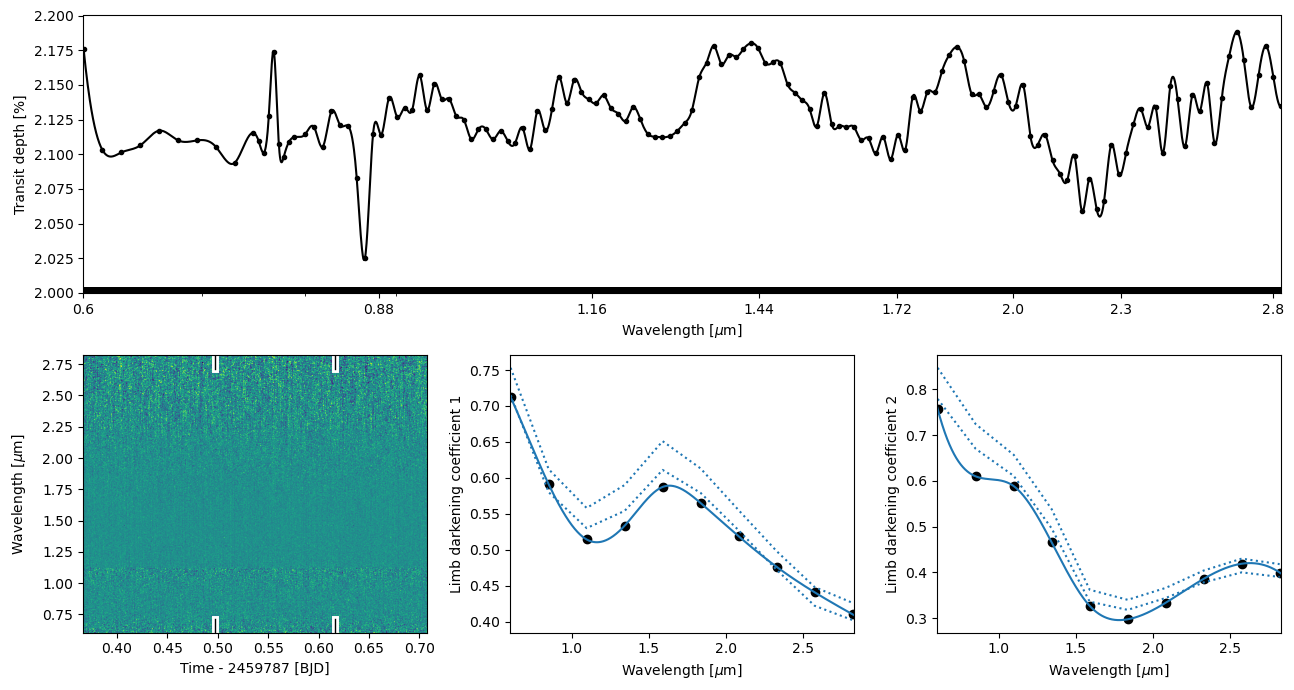

In [20]:
ts.plot_fit('fit', **pargs)

## Posterior sampling

In [21]:
ts.reset_sampler()

In [22]:
ts.sample(1000, thin=100, repeats=2, pool=pool, lnpost=lnpostf)

MCMC sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Run 1/2:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 2/2:   0%|          | 0/1000 [00:00<?, ?it/s]

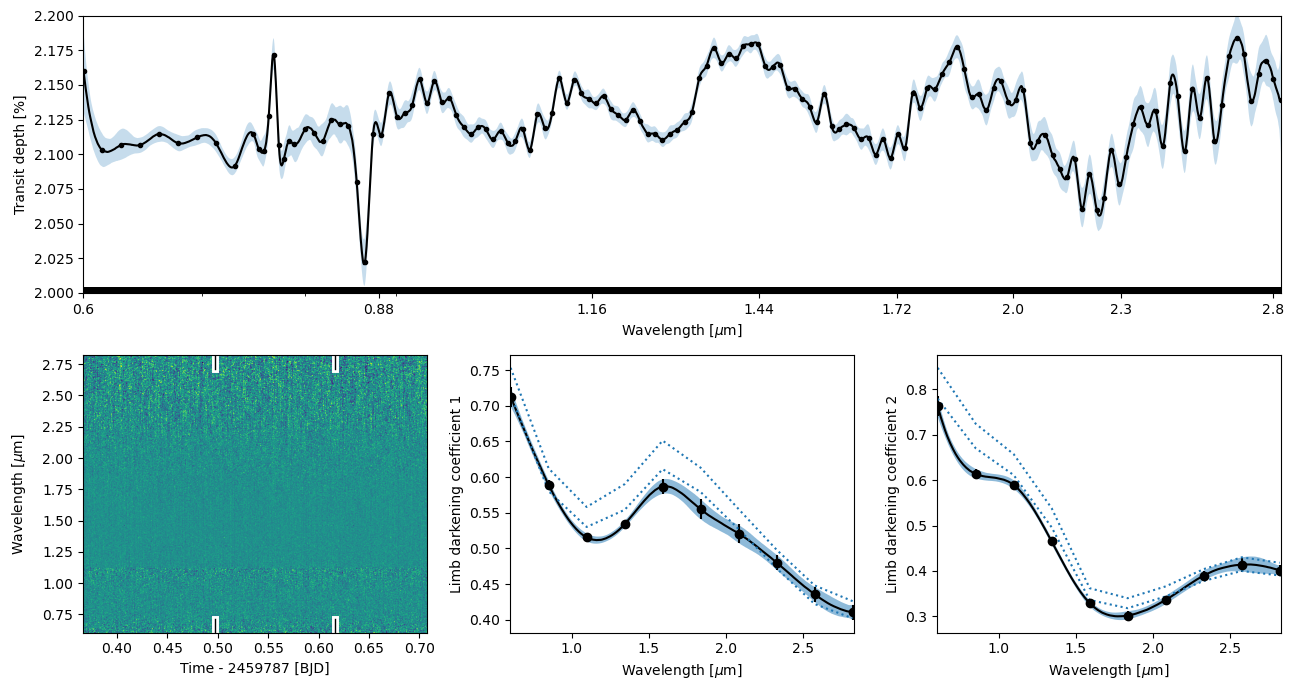

In [23]:
ts.plot_fit(result='mcmc', **pargs)

### Save the results

In [25]:
ts.save(overwrite=True)

---

<center>&copy;2024 Hannu Parviainen</center>